# Overview

This dataset is from Kaggle competition: https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection

This dataset contains the information about mobile fradulent events in China.

The goal is to use the information given to predict whether a phone call is fradulent or not.

# Load data

In [1]:
# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# Model Classifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model selection
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
# from sklearn.metrics import (precision_recall_curve, auc, roc_curve, recall_score, classification_report, precision_recall_fscore_support)

# Model persistence
import pickle

# Others
import warnings
import gc

# Visualization
import seaborn as sns
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

/Users/liyingli/anaconda3/envs/ml/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings
from random import sample
# warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
talking = pd.read_csv('./data/sample.csv') 
talking['click_time'] = pd.to_datetime(talking['click_time'], errors='coerce')

# Data overview

We take a look at the size of the data, the type of each columns of the data.

Also we checked the head and tail of the data to check there is no anormality in the data.

Finally, we took a sample from the data and realize that this is potentially imbalanced dataset.

So we did further exploration in the next section and dealt with it.

Predictors: 

• ip: ip address of click

• app: app id for marketing

• device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)

• os: os version id of user mobile phone

• channel: channel id of mobile ad publisher

• click_time: timestamp of click (UTC)

• attributed_time: if user download the app for after clicking an ad, this is the time of the app download

Target:

• is_attributed: the target that is to be predicted, indicating the app was downloaded

In [5]:
len(talking)

20000000

In [6]:
talking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000000 entries, 0 to 19999999
Data columns (total 8 columns):
ip                 int64
app                int64
device             int64
os                 int64
channel            int64
click_time         datetime64[ns]
attributed_time    object
is_attributed      int64
dtypes: datetime64[ns](1), int64(6), object(1)
memory usage: 1.2+ GB


In [7]:
talking.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,292045,14,1,25,118,2017-11-08 17:10:15,NaN,0
1,124002,3,1,53,409,2017-11-06 23:55:15,NaN,0
2,83481,3,1,13,280,2017-11-08 00:28:36,NaN,0
3,40245,14,1,37,371,2017-11-08 00:35:31,NaN,0
4,104838,9,1,13,127,2017-11-09 14:58:25,NaN,0


In [8]:
talking.tail()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
19999995,123531,3,1,8,280,2017-11-09 06:55:43,NaN,0
19999996,25158,3,1,17,115,2017-11-07 13:09:39,NaN,0
19999997,65676,1,1,19,452,2017-11-09 15:01:33,NaN,0
19999998,39867,14,1,19,134,2017-11-07 10:13:48,NaN,0
19999999,41052,26,1,19,266,2017-11-06 17:07:02,NaN,0


In [9]:
talking.sample(5) ## imbalanced data

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
18540188,53454,26,1,19,121,2017-11-08 13:12:31,NaN,0
11276804,133730,27,1,13,122,2017-11-08 23:35:38,NaN,0
14313162,54472,1,1,25,134,2017-11-07 12:43:36,NaN,0
10598437,120112,17,1,1,128,2017-11-09 15:02:39,NaN,0
9504891,95111,2,1,1,469,2017-11-07 15:50:08,NaN,0


# Explore the data

## Preprocess raw features

In [10]:
# transform click_time into day, hour, minute and second
talking['day'] = talking['click_time'].dt.day
talking['hour'] = talking['click_time'].dt.hour
talking['minute'] = talking['click_time'].dt.minute
talking['second'] = talking['click_time'].dt.second
talking.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second
0,292045,14,1,25,118,2017-11-08 17:10:15,NaN,0,8,17,10,15
1,124002,3,1,53,409,2017-11-06 23:55:15,NaN,0,6,23,55,15
2,83481,3,1,13,280,2017-11-08 00:28:36,NaN,0,8,0,28,36
3,40245,14,1,37,371,2017-11-08 00:35:31,NaN,0,8,0,35,31
4,104838,9,1,13,127,2017-11-09 14:58:25,NaN,0,9,14,58,25


In [11]:
# ip, app, device, os, channel, is_attributed and the time features we just created
# are encoded to be integers, we tranform them into categorical data
heads = talking.columns
print(heads)
for i in list(range(0,5)) + [6]:
    talking[heads[i]] = talking[heads[i]].astype('category')
talking.info()

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time',
       'is_attributed', 'day', 'hour', 'minute', 'second'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000000 entries, 0 to 19999999
Data columns (total 12 columns):
ip                 category
app                category
device             category
os                 category
channel            category
click_time         datetime64[ns]
attributed_time    category
is_attributed      int64
day                int64
hour               int64
minute             int64
second             int64
dtypes: category(6), datetime64[ns](1), int64(5)
memory usage: 1.2 GB


# Down Sample  
we have 20 m rows of labelled unbalanced data, and 20000 unbalanced sample data.
Use 20000 sample data to do all initial vis and all feature engineering related vis.
split 20m into 2m test unbalanced data and 18m raw data.
from 18m raw data we can extract 90000 raw balanced data.
we use 10000 to select best classifers(1 or 2) and best feature engineering.
we use 80000 to select best parameter for 1 classifer and 1 feature engineering.
then we use this best model to do prediction on the 2m test set. 

In [12]:
# down sample the train set
df_majority = talking[talking.is_attributed==0]
df_minority = talking[talking.is_attributed==1]

df_majority_downsampled = df_majority.sample(replace=False,    # sample without replacement
                                frac=len(df_minority)/len(df_majority),     
                                random_state=42) # reproducible results

balanced_train = pd.concat([df_majority_downsampled, df_minority])
balanced_train = balanced_train.sample(frac=1)

balanced_train = balanced_train.drop(columns=['click_time','attributed_time'])
balanced_train['is_attributed'] = balanced_train['is_attributed'].astype('int64')

In [13]:
# split 20m into 2m train data and 18m validation data.
train = balanced_train.sample(frac=0.1, replace=False, random_state = 42)
valid = balanced_train.drop(train.index)

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9878 entries, 13103052 to 4140857
Data columns (total 10 columns):
ip               9878 non-null category
app              9878 non-null category
device           9878 non-null category
os               9878 non-null category
channel          9878 non-null category
is_attributed    9878 non-null int64
day              9878 non-null int64
hour             9878 non-null int64
minute           9878 non-null int64
second           9878 non-null int64
dtypes: category(5), int64(5)
memory usage: 7.1 MB


# Train Model with Raw Data

In [15]:
train_c = train

In [16]:
train_c[['day', 'hour', 'minute', 'second']] = train_c[['day', 'hour', 'minute', 'second']].astype('category')

In [17]:
y = np.ravel(np.array(train_c['is_attributed']))
X = np.array(train_c.drop(columns=['is_attributed']))

In [18]:
pip_knn = Pipeline([('clf', KNeighborsClassifier())])
pip_rfc = Pipeline([('clf', RandomForestClassifier(n_estimators=100))])
pip_lr = Pipeline([('clf', LogisticRegression(solver='lbfgs'))])
pip_gnb = Pipeline([('clf', GaussianNB())])
pip_gbc = Pipeline([('clf', GradientBoostingClassifier())])
pip_mlp = Pipeline([('clf', MLPClassifier())])
pip_svc1 = Pipeline([('clf', LinearSVC())])
pip_svc2 = Pipeline([('clf', SVC())])
pip_xgb = Pipeline([('clf', XGBClassifier())])
pip_lgb = Pipeline([('clf', LGBMClassifier())])

pipelines = [pip_knn, pip_rfc, pip_lgb, pip_lr, pip_gnb, pip_gbc, pip_mlp, pip_svc1, pip_svc2, pip_xgb]

In [19]:
warnings.filterwarnings('ignore')

plot_df = pd.DataFrame(columns=['type','roc_auc_score','f1_score'])
for i in range(0, 100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i*2)
    for pipe in pipelines:
        pipe.fit(X_train, y_train)
        name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
        a = roc_auc_score(y_test, pipe.predict(X_test))
        b = f1_score(pipe.predict(X_test),y_test)
        plot_df = plot_df.append({'type':name,'roc_auc_score':a, 'f1_score':b}, ignore_index=True)

In [20]:
plot_df.sort_values(['roc_auc_score', 'f1_score'], ascending=[False, False])[:20]

,type,roc_auc_score,f1_score
742,LGBMClassifier,0.922971,0.919708
991,RandomForestClassifier,0.921139,0.917844
885,GradientBoostingClassifier,0.920555,0.916579
92,LGBMClassifier,0.920459,0.916799
741,RandomForestClassifier,0.919952,0.916493
95,GradientBoostingClassifier,0.918917,0.914163
995,GradientBoostingClassifier,0.918668,0.914826
882,LGBMClassifier,0.918397,0.915625
392,LGBMClassifier,0.918271,0.915638
745,GradientBoostingClassifier,0.918025,0.913956


In [21]:
plot_df.sort_values(['roc_auc_score', 'f1_score'], ascending=[False, False]).to_csv('model_selection.csv', sep=",",encoding='utf-8')

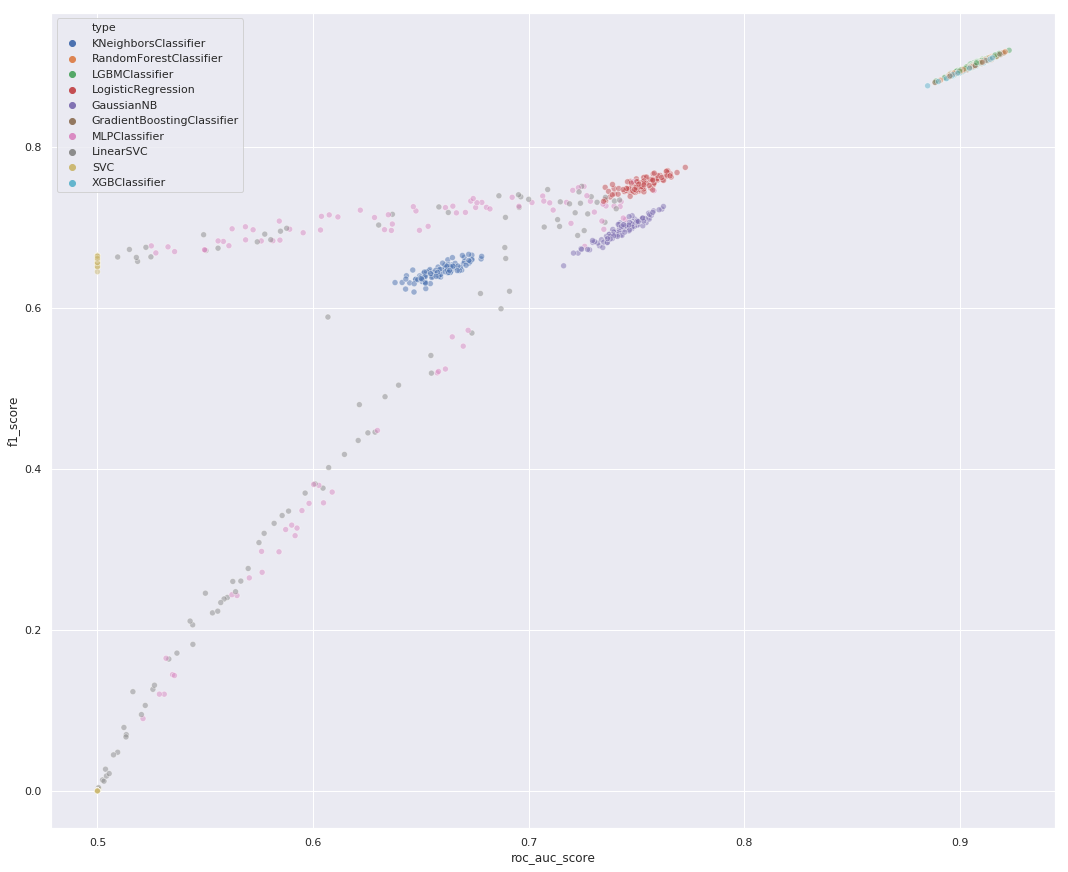

In [22]:
sns.set(rc={'figure.figsize':(18,15)})
ax = sns.scatterplot(x="roc_auc_score", y="f1_score", hue="type", data=plot_df, alpha=0.5)

According to mean accuracy score and f1 score, the best three models are **random forest**, **gradient booosting** and **XGBoost**.

# Revise Models Using Feature Engineering

## Feature Engineering: Group-By-Aggregation

In [23]:
train_fe = train

In [24]:
train_fe[['day', 'hour', 'minute', 'second']] = train_fe[['day', 'hour', 'minute', 'second']].astype('float')
train_fe[['ip', 'app', 'device', 'os', 'channel']] = train_fe[['ip', 'app', 'device', 'os', 'channel']].astype('category')

In [25]:
train_fe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9878 entries, 13103052 to 4140857
Data columns (total 10 columns):
ip               9878 non-null category
app              9878 non-null category
device           9878 non-null category
os               9878 non-null category
channel          9878 non-null category
is_attributed    9878 non-null int64
day              9878 non-null float64
hour             9878 non-null float64
minute           9878 non-null float64
second           9878 non-null float64
dtypes: category(5), float64(4), int64(1)
memory usage: 7.1 MB


In [26]:
# Define all the groupby transformations
groupby_aggregations = [
    
    # V1 - GroupBy Features #
    #########################    
    # Variance in day, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'day', 'agg': 'var'},
    # Variance in hour, for ip-app-os
    {'groupby': ['ip','app','os'], 'select': 'hour', 'agg': 'var'},
    # Count, for ip-day-hour
    {'groupby': ['ip','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app
    {'groupby': ['ip', 'app'], 'select': 'channel', 'agg': 'count'},        
    # Count, for ip-app-os
    {'groupby': ['ip', 'app', 'os'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app-day-hour
    {'groupby': ['ip','app','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Mean hour, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'hour', 'agg': 'mean'}, 
    
    # V2 - GroupBy Features #
    #########################
    # Average clicks on app by distinct users; is it an app they return to?
    {'groupby': ['app'], 
     'select': 'ip', 
     'agg': lambda x: np.divide(float(len(x)),float(len(x.unique()))), 
     'agg_name': 'AvgViewPerDistinct'
    },
    # How popular is the app or channel?
    {'groupby': ['app'], 'select': 'channel', 'agg': 'count'},
    {'groupby': ['channel'], 'select': 'app', 'agg': 'count'},
    
    # V3 - GroupBy Features                                              #
    # https://www.kaggle.com/bk0000/non-blending-lightgbm-model-lb-0-977 #
    ###################################################################### 
    {'groupby': ['ip'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'nunique'}, 
    {'groupby': ['ip','day'], 'select': 'hour', 'agg': 'nunique'}, 
    {'groupby': ['ip','app'], 'select': 'os', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'device', 'agg': 'nunique'}, 
    {'groupby': ['app'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip', 'device', 'os'], 'select': 'app', 'agg': 'nunique'}, 
    {'groupby': ['ip','device','os'], 'select': 'app', 'agg': 'cumcount'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'cumcount'}, 
    {'groupby': ['ip'], 'select': 'os', 'agg': 'cumcount'}, 
    {'groupby': ['ip','day','channel'], 'select': 'hour', 'agg': 'var'}    
]



new_features =[]
# Apply all the groupby transformations
for spec in groupby_aggregations:
    
    # Name of the aggregation we're applying
    agg_name = spec['agg_name'] if 'agg_name' in spec else spec['agg']
    
    # Name of new feature
    new_feature = '{}_{}_{}'.format('_'.join(spec['groupby']), agg_name, spec['select'])
    new_features.append(new_feature)
    
    # Info
    print("Grouping by {}, and aggregating {} with {}".format(
        spec['groupby'], spec['select'], agg_name
    ))
    
    # Unique list of features to select
    all_features = list(set(spec['groupby'] + [spec['select']]))
    
    # Perform the groupby
    gp = train_fe[all_features]. \
        groupby(spec['groupby'])[spec['select']]. \
        agg(spec['agg']). \
        reset_index(). \
        rename(index=str, columns={spec['select']: new_feature})
        
    # Merge back to X_total
    if 'cumcount' == spec['agg']:
        train_fe[new_feature] = gp[0].values
    else:
        # train_fe[spec['groupby']] = train_fe[spec['groupby']].astype('category')
        train_fe = train_fe.merge(gp, on=spec['groupby'], how='left')
        
     # Clear memory
    del gp
    gc.collect()

train_fe.head()

Grouping by ['ip', 'app', 'channel'], and aggregating day with var
Grouping by ['ip', 'app', 'os'], and aggregating hour with var
Grouping by ['ip', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app'], and aggregating channel with count
Grouping by ['ip', 'app', 'os'], and aggregating channel with count
Grouping by ['ip', 'app', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app', 'channel'], and aggregating hour with mean
Grouping by ['app'], and aggregating ip with AvgViewPerDistinct
Grouping by ['app'], and aggregating channel with count
Grouping by ['channel'], and aggregating app with count
Grouping by ['ip'], and aggregating channel with nunique
Grouping by ['ip'], and aggregating app with nunique
Grouping by ['ip', 'day'], and aggregating hour with nunique
Grouping by ['ip', 'app'], and aggregating os with nunique
Grouping by ['ip'], and aggregating device with nunique
Grouping by ['app'], and aggregating channel with nunique
Grou

,ip,app,device,os,channel,is_attributed,day,hour,minute,second,...,ip_nunique_app,ip_day_nunique_hour,ip_app_nunique_os,ip_nunique_device,app_nunique_channel,ip_device_os_nunique_app,ip_device_os_cumcount_app,ip_cumcount_app,ip_cumcount_os,ip_day_channel_var_hour
0,235418,2,1,19,219,0,8.0,2.0,51.0,51.0,...,1,1,1,1,20,1,0,0,0,NaN
1,247703,35,1,13,274,1,8.0,2.0,27.0,14.0,...,1,1,1,1,2,1,0,0,0,NaN
2,66665,19,0,38,210,1,9.0,13.0,16.0,41.0,...,1,1,1,1,8,1,0,0,0,NaN
3,49570,19,0,21,213,1,7.0,4.0,57.0,42.0,...,2,2,1,2,8,1,0,0,0,NaN
4,6155,19,58,24,213,1,8.0,9.0,31.0,26.0,...,1,1,1,1,8,1,0,0,0,NaN


In [27]:
base_features = ['ip', 'app', 'device', 'os', 'channel']

### Model

#### xgboost

[Text(0, 0.5, 'roc_auc_score')]

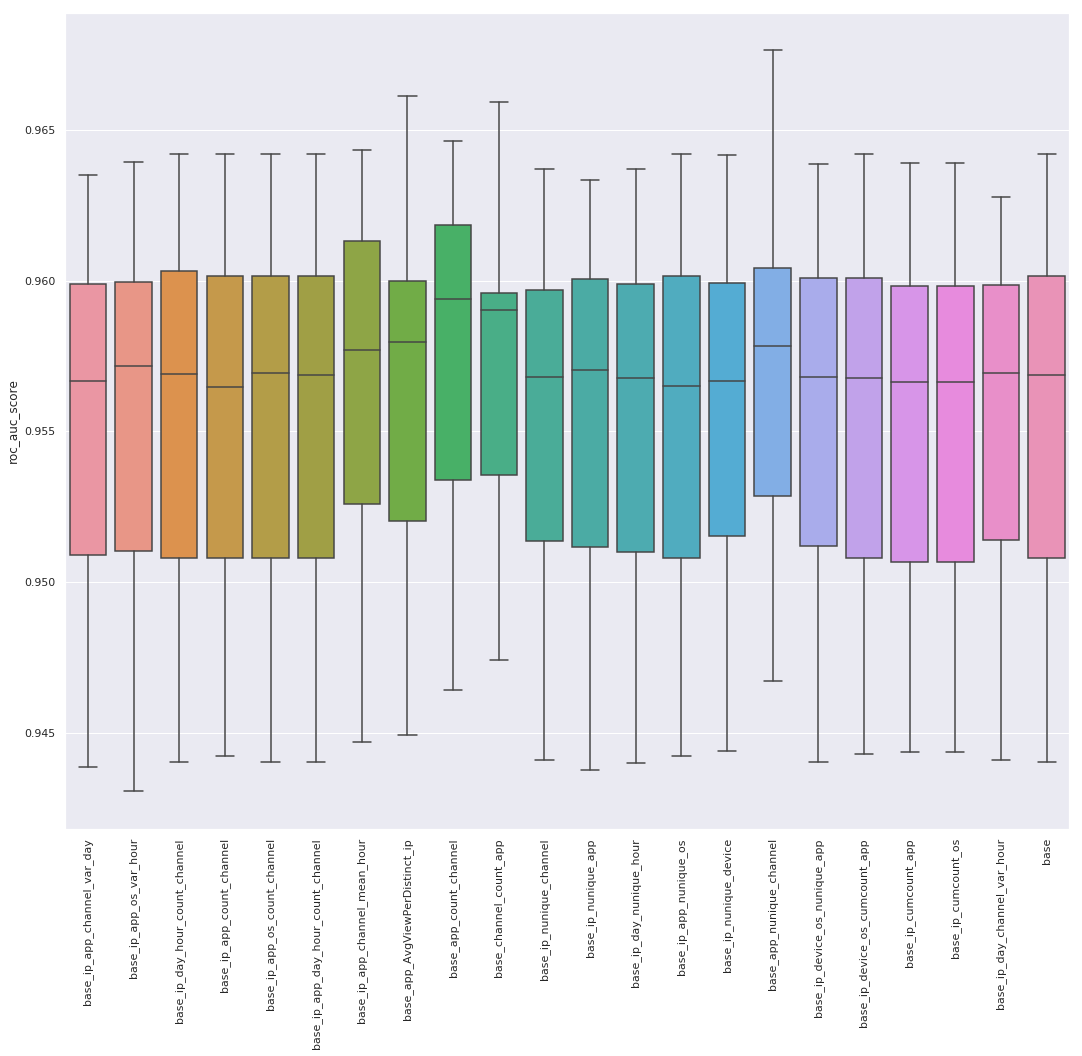

In [28]:
df_xgb = pd.DataFrame(columns = ['base_'+str(f) for f in new_features])
for f in new_features:
    X = np.array(train_fe[['ip', 'app', 'device', 'os', 'channel',f]])
    y = np.array(train_fe['is_attributed'])
    kf = KFold(n_splits = 10, random_state = 7)
    for train, test in kf.split(X):
        clf = XGBClassifier()
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        clf.fit(X_train,y_train)
        y_pro = clf.predict_proba(X_test)[:, 1]
        df_xgb = df_xgb.append({'base_'+str(f): roc_auc_score(y_test, y_pro)},ignore_index=True)

X = np.array(train_fe[base_features])
y = np.array(train_fe['is_attributed'])
kf = KFold(n_splits = 10, random_state = 7)
for train, test in kf.split(X):
    clf = XGBClassifier()
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
    clf.fit(X_train,y_train)
    y_pro = clf.predict_proba(X_test)[:, 1]
    df_xgb = df_xgb.append({'base': roc_auc_score(y_test, y_pro)},ignore_index=True)

ax = sns.boxplot(data = df_xgb)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set(ylabel='roc_auc_score')

#### Random Forest

In [29]:
train_fe_fill = train_fe
train_fe_fill[['ip_app_channel_var_day','ip_app_os_var_hour','ip_day_channel_var_hour']] = \
               train_fe_fill[['ip_app_channel_var_day','ip_app_os_var_hour','ip_day_channel_var_hour']].\
               fillna(0)

In [30]:
train_fe_fill[['ip', 'app', 'device', 'os', 'channel']] \
    = train_fe_fill[['ip', 'app', 'device', 'os', 'channel']].astype('object')
# data_aggregate['is_attributed'] = data_aggregate['is_attributed'].astype('int64')
# data_aggregate.columns

[Text(0, 0.5, 'roc_auc_score')]

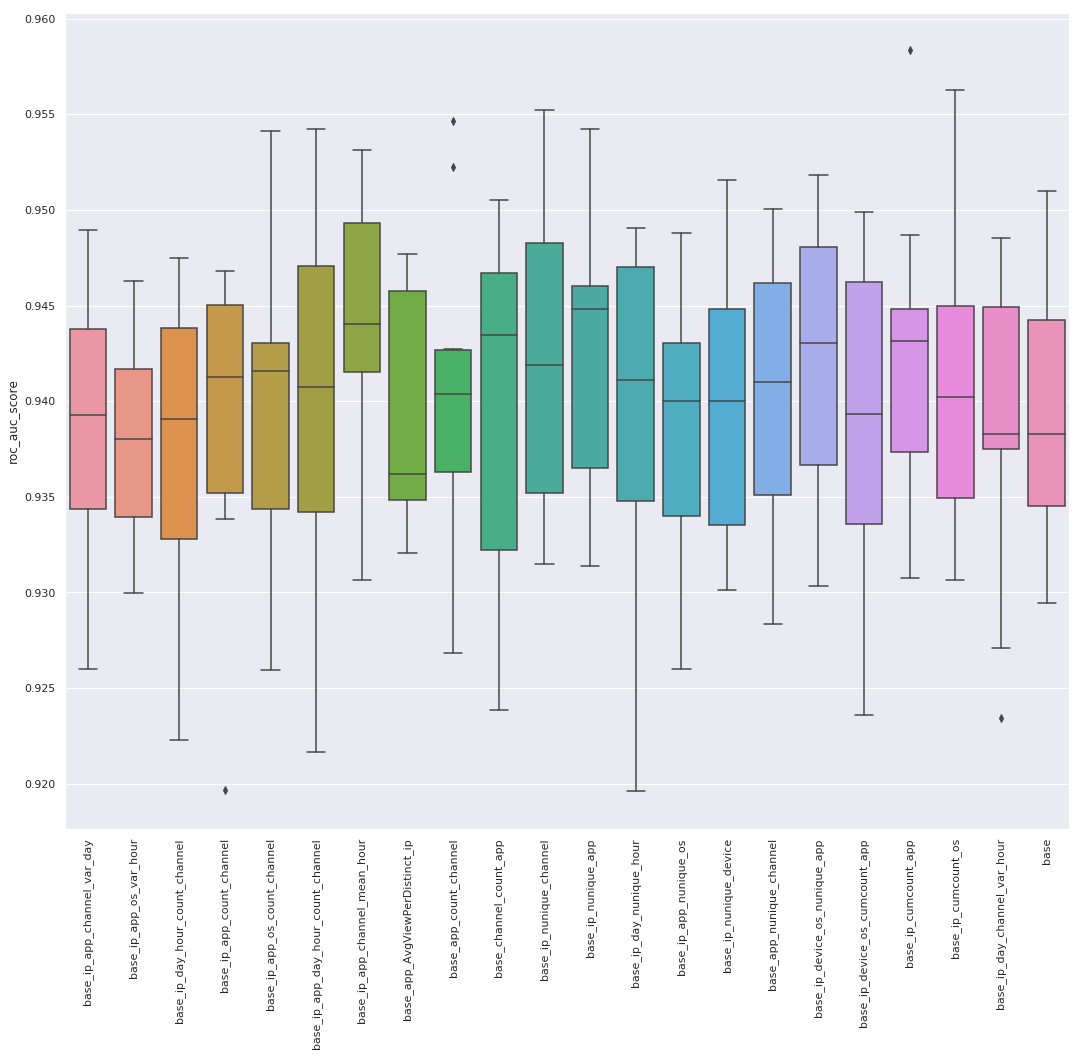

In [31]:
df_rf= pd.DataFrame(columns = ['base_'+str(f) for f in new_features])
for f in new_features:
    X = np.array(train_fe_fill[base_features].join(train_fe_fill[f]))
    y = np.array(train_fe_fill['is_attributed'])
    kf = KFold(n_splits = 10, random_state = 7)
    for train, test in kf.split(X):
        clf = RandomForestClassifier()
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        clf.fit(X_train,y_train)
        y_pro = clf.predict_proba(X_test)[:, 1]
        df_rf = df_rf.append({'base_'+str(f): roc_auc_score(y_test, y_pro)},ignore_index=True)
        

X = np.array(train_fe_fill[base_features])
y = np.array(train_fe_fill['is_attributed'])
kf = KFold(n_splits = 10, random_state = 7)
for train, test in kf.split(X):
    clf = RandomForestClassifier()
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
    clf.fit(X_train,y_train)
    y_pro = clf.predict_proba(X_test)[:, 1]
    df_rf = df_rf.append({'base': roc_auc_score(y_test, y_pro)},ignore_index=True)
    

ax = sns.boxplot(data = df_rf)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set(ylabel='roc_auc_score')

#### Gradient Boosting

[Text(0, 0.5, 'roc_auc_score')]

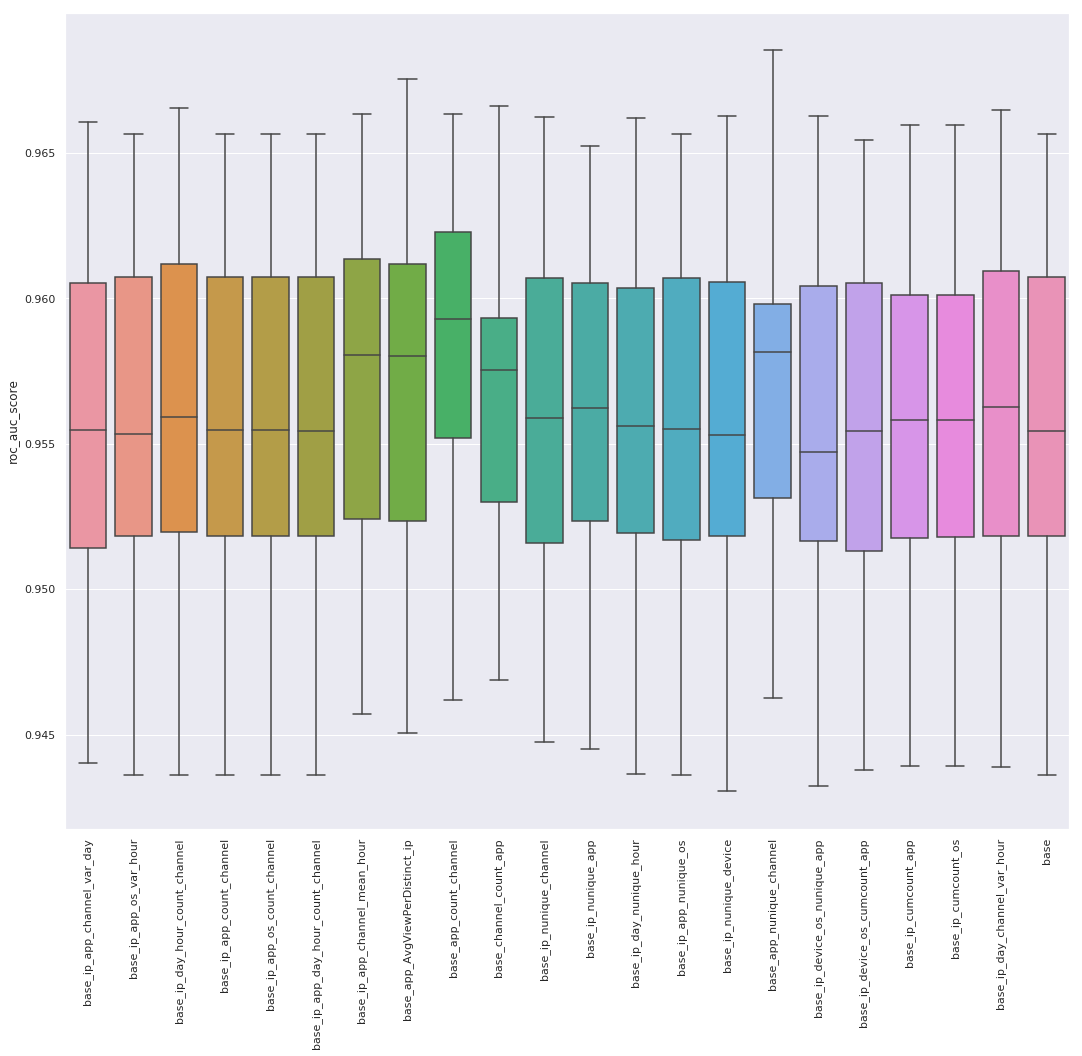

In [32]:
df_gb = pd.DataFrame(columns = ['base_'+str(f) for f in new_features])
for f in new_features:
    X = np.array(train_fe[['ip', 'app', 'device', 'os', 'channel',f]])
    y = np.array(train_fe['is_attributed'])
    kf = KFold(n_splits = 10, random_state = 7)
    for train, test in kf.split(X):
        clf = GradientBoostingClassifier()
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        clf.fit(X_train,y_train)
        y_pro = clf.predict_proba(X_test)[:, 1]
        df_gb = df_gb.append({'base_'+str(f): roc_auc_score(y_test, y_pro)},ignore_index=True)

X = np.array(train_fe[base_features])
y = np.array(train_fe['is_attributed'])
kf = KFold(n_splits = 10, random_state = 7)
for train, test in kf.split(X):
    clf = GradientBoostingClassifier()
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
    clf.fit(X_train,y_train)
    y_pro = clf.predict_proba(X_test)[:, 1]
    df_gb = df_gb.append({'base': roc_auc_score(y_test, y_pro)},ignore_index=True)

ax = sns.boxplot(data = df_gb)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set(ylabel='roc_auc_score')

#### LightGB

[Text(0, 0.5, 'roc_auc_score')]

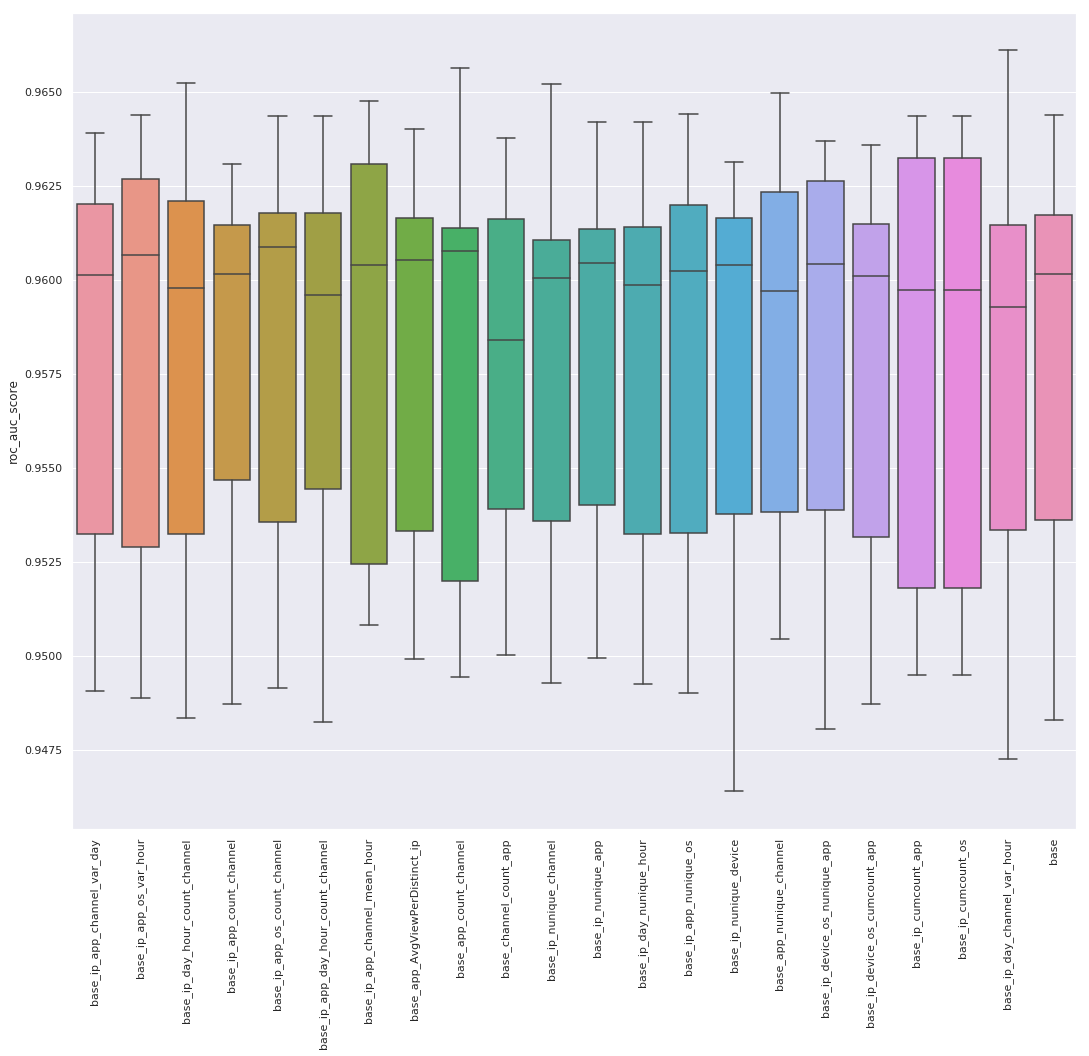

In [72]:
df_lgb = pd.DataFrame(columns = ['base_'+str(f) for f in new_features])
for f in new_features:
    X = np.array(train_fe[['ip', 'app', 'device', 'os', 'channel',f]])
    y = np.array(train_fe['is_attributed'])
    kf = KFold(n_splits = 10, random_state = 7)
    for train, test in kf.split(X):
        clf = LGBMClassifier()
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        clf.fit(X_train,y_train)
        y_pro = clf.predict_proba(X_test)[:, 1]
        df_lgb = df_lgb.append({'base_'+str(f): roc_auc_score(y_test, y_pro)},ignore_index=True)

X = np.array(train_fe[base_features])
y = np.array(train_fe['is_attributed'])
kf = KFold(n_splits = 10, random_state = 7)
for train, test in kf.split(X):
    clf = LGBMClassifier()
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
    clf.fit(X_train,y_train)
    y_pro = clf.predict_proba(X_test)[:, 1]
    df_lgb = df_lgb.append({'base': roc_auc_score(y_test, y_pro)},ignore_index=True)

ax = sns.boxplot(data = df_lgb)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set(ylabel='roc_auc_score')

In [34]:
train_fe.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'is_attributed', 'day', 'hour',
       'minute', 'second', 'ip_app_channel_var_day', 'ip_app_os_var_hour',
       'ip_day_hour_count_channel', 'ip_app_count_channel',
       'ip_app_os_count_channel', 'ip_app_day_hour_count_channel',
       'ip_app_channel_mean_hour', 'app_AvgViewPerDistinct_ip',
       'app_count_channel', 'channel_count_app', 'ip_nunique_channel',
       'ip_nunique_app', 'ip_day_nunique_hour', 'ip_app_nunique_os',
       'ip_nunique_device', 'app_nunique_channel', 'ip_device_os_nunique_app',
       'ip_device_os_cumcount_app', 'ip_cumcount_app', 'ip_cumcount_os',
       'ip_day_channel_var_hour'],
      dtype='object')

## Model with all features

In [40]:
y_all = np.array(train_fe['is_attributed'])
X_all = np.array(train_fe.drop(columns = ['is_attributed']))

In [57]:
pip_rfc = Pipeline([('clf', RandomForestClassifier(n_estimators=100))])
pip_gbc = Pipeline([('clf', GradientBoostingClassifier())])
pip_xgb = Pipeline([('clf', XGBClassifier(n_estimators=100, learning_rate=0.1))])
pip_lgb = Pipeline([('clf', LGBMClassifier())])

pipelines_all = [pip_gbc, pip_rfc, pip_lgb, pip_xgb]

In [58]:
warnings.filterwarnings('ignore')

plot_df_all = pd.DataFrame(columns=['type','roc_auc_score','f1_score'])
for i in range(0, 100):
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=i*2)
    for pipe in pipelines_all:
        pipe.fit(X_train, y_train)
        name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
        a = roc_auc_score(y_test, pipe.predict(X_test))
        b = f1_score(pipe.predict(X_test),y_test)
        plot_df_all = plot_df_all.append({'type':name,'roc_auc_score':a, 'f1_score':b}, ignore_index=True)

In [59]:
plot_df_all.sort_values(['roc_auc_score', 'f1_score'], ascending=[False, False])[:20]

,type,roc_auc_score,f1_score
38,LGBMClassifier,0.926037,0.923077
396,GradientBoostingClassifier,0.924715,0.921301
398,LGBMClassifier,0.923570,0.921080
37,RandomForestClassifier,0.923487,0.919638
36,GradientBoostingClassifier,0.922486,0.919005
39,XGBClassifier,0.922467,0.918226
352,GradientBoostingClassifier,0.922017,0.918635
220,GradientBoostingClassifier,0.921820,0.917685
388,GradientBoostingClassifier,0.921719,0.916933
298,LGBMClassifier,0.921286,0.918863


In [60]:
plot_df_all.sort_values(['roc_auc_score', 'f1_score'], ascending=[False, False]).to_csv('model_selection_all.csv', sep=",",encoding='utf-8')

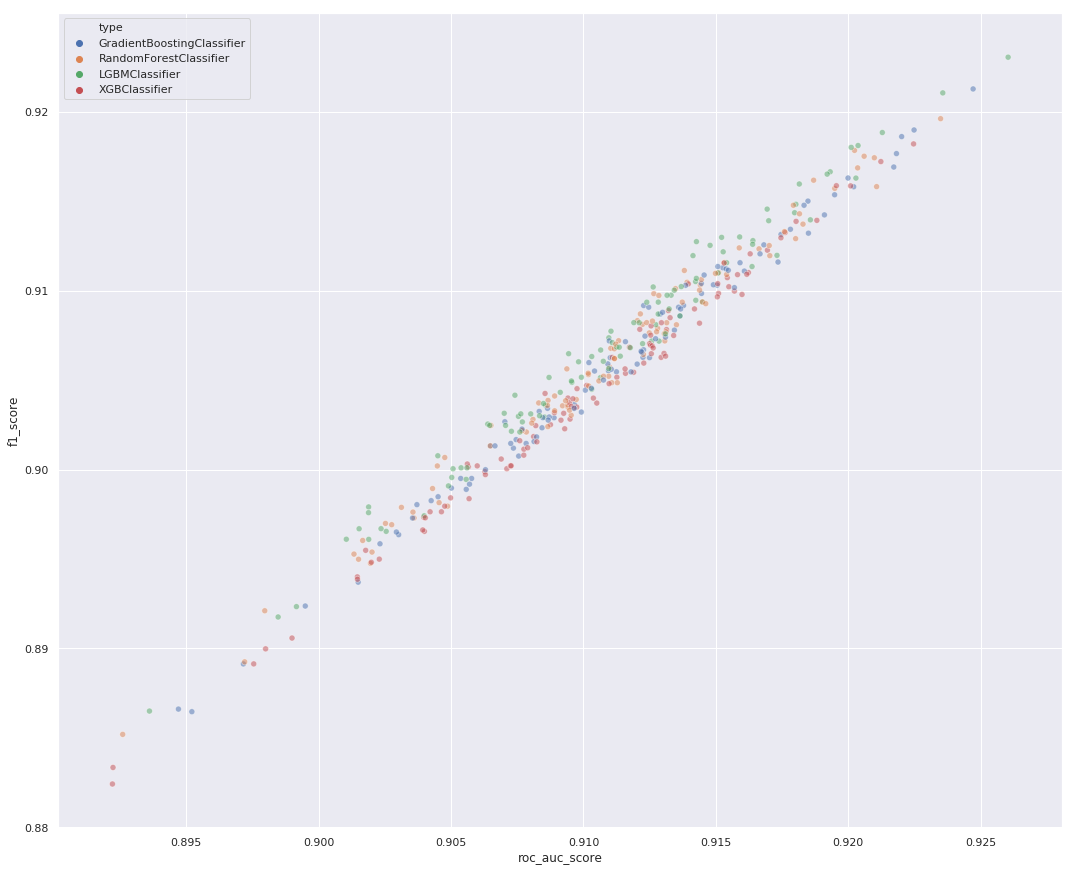

In [61]:
sns.set(rc={'figure.figsize':(18,15)})
ax = sns.scatterplot(x="roc_auc_score", y="f1_score", hue="type", data=plot_df_all, alpha=0.5)

In [70]:
plot_df_all.groupby('type').mean().sort_values(['roc_auc_score', 'f1_score'], ascending=[False, False])

,roc_auc_score,f1_score
type,,
GradientBoostingClassifier,0.911179,0.905893
LGBMClassifier,0.911063,0.906818
RandomForestClassifier,0.910907,0.906003
XGBClassifier,0.910035,0.904106


In [74]:
plot_df.groupby('type').max().sort_values(['roc_auc_score', 'f1_score'], ascending=[False, False])

,roc_auc_score,f1_score
type,,
LGBMClassifier,0.926037,0.923077
GradientBoostingClassifier,0.922486,0.919005
XGBClassifier,0.922467,0.918226
RandomForestClassifier,0.921463,0.917844
LogisticRegression,0.772742,0.774323
GaussianNB,0.762595,0.725778
MLPClassifier,0.758231,0.756385
LinearSVC,0.742241,0.750803
KNeighborsClassifier,0.678271,0.666324


In [55]:
plot_df_all1 = pd.DataFrame(columns=['type','roc_auc_score','f1_score'])
for i in range(0, 100):
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=i*5)
    lgb1 = LGBMClassifier()
    lgb1.fit(X_train, y_train)
    name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
    a = roc_auc_score(y_test, pipe.predict(X_test))
    b = f1_score(pipe.predict(X_test),y_test)
    plot_df_all1 = plot_df_all1.append({'type':name,'roc_auc_score':a, 'f1_score':b}, ignore_index=True)

In [56]:
plot_df_all1.groupby('type').mean().sort_values(['roc_auc_score', 'f1_score'], ascending=[False, False])

,roc_auc_score,f1_score
type,,
XGBClassifier,0.915563,0.910078


In [ ]:
def grid_search_xgb(X_train, X_test, y_train, y_test):
    xg = xgb.XGBClassifier()
    
    grid_params = {'n_estimators': [100, 200, 400],
                   'learning_rate': [0.05, 0.1, 0.5],
                   'max_depth' : range(2,5)}
                    

    gs = GridSearchCV(estimator=xg,  
                      param_grid=grid_params,
                      scoring='roc_auc',
                      cv=5)

    gs.fit(X_train, y_train)
    y_pred = gs.predict(X_test)
    score = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_pred, y_test)
    best_params = gs.best_params_
    
    return score, roc_auc, best_params

## Feature Engineering 2: Time till next click

In [43]:
data_time = train_fe

In [44]:
group_by_next_click = [
    
    # V1
    {'groupby': ['ip']},
    {'groupby': ['ip', 'app']},
    {'groupby': ['ip', 'channel']},
    {'groupby': ['ip', 'os']},
    
    # V2
    {'groupby': ['ip', 'app', 'device', 'os', 'channel']},
    {'groupby': ['ip', 'os', 'device']},
    {'groupby': ['ip', 'os', 'device', 'app']}
]

new_features3 =[]
# Calculate the time to next click for each group
for spec in group_by_next_click:
    
    # Name of new feature
    new_feature = '{}_nextClick'.format('_'.join(spec['groupby']))    
    new_features3.append(new_feature)
    
    # Unique list of features to select
    all_features = spec['groupby'] + ['click_time']
    
    # Run calculation
    print(f">> Grouping by {spec['groupby']}, and saving time to next click in: {new_feature}")
    data_time[new_feature] = data_time[all_features].groupby(spec['groupby']).click_time.transform(lambda x: x.diff().shift(-1)).dt.seconds
    #datetime minus the previous one and convert to seconds
data_time.head()

>> Grouping by ['ip'], and saving time to next click in: ip_nextClick
>> Grouping by ['ip', 'app'], and saving time to next click in: ip_app_nextClick
>> Grouping by ['ip', 'channel'], and saving time to next click in: ip_channel_nextClick
>> Grouping by ['ip', 'os'], and saving time to next click in: ip_os_nextClick
>> Grouping by ['ip', 'app', 'device', 'os', 'channel'], and saving time to next click in: ip_app_device_os_channel_nextClick
>> Grouping by ['ip', 'os', 'device'], and saving time to next click in: ip_os_device_nextClick
>> Grouping by ['ip', 'os', 'device', 'app'], and saving time to next click in: ip_os_device_app_nextClick


,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,...,ip_cumcount_app,ip_cumcount_os,ip_day_channel_var_hour,ip_nextClick,ip_app_nextClick,ip_channel_nextClick,ip_os_nextClick,ip_app_device_os_channel_nextClick,ip_os_device_nextClick,ip_os_device_app_nextClick
0,44747,26,1,73,121,2017-11-06 16:22:54,NaN,0,6,16,...,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,110064,23,1,18,153,2017-11-07 02:24:40,NaN,0,7,2,...,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,62892,18,3032,607,107,2017-11-06 18:16:35,NaN,0,6,18,...,0,0,0.0,19034.0,19034.0,NaN,NaN,NaN,NaN,NaN
3,46475,28,1,18,135,2017-11-06 16:39:30,NaN,0,6,16,...,0,0,0.0,23989.0,NaN,NaN,NaN,NaN,NaN,NaN
4,140919,37,1,9,213,2017-11-06 21:24:48,2017-11-06 21:25:45,1,6,21,...,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### XGBoost

[Text(0, 0.5, 'roc_auc_score')]

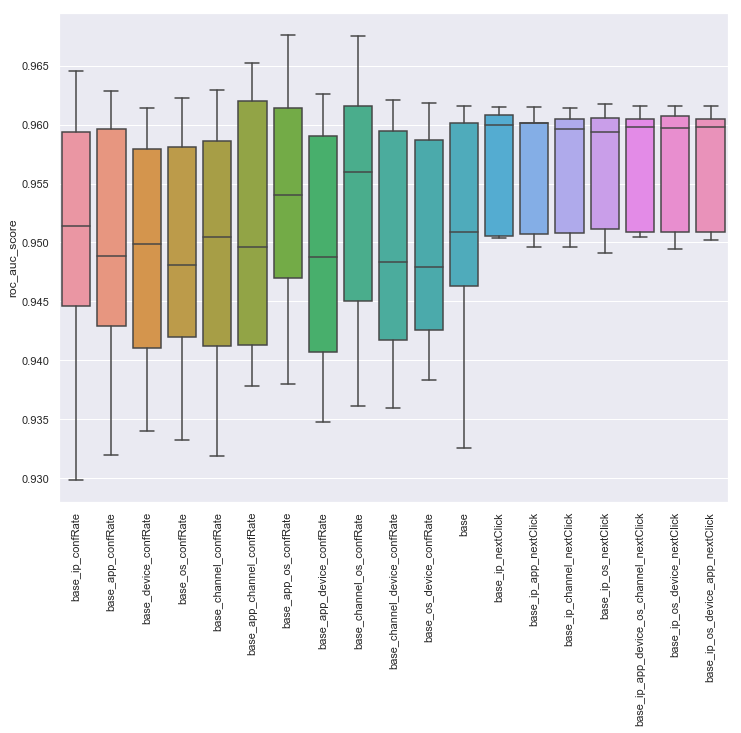

In [45]:
base_features = ['ip', 'app', 'device', 'os', 'channel']
df3 = pd.DataFrame(columns = ['base_'+str(f) for f in new_features3])

for f in new_features3:
    X = np.array(data_time[base_features].join(data_time[f]))
    y = np.array(data_time['is_attributed'])
    kf = KFold(n_splits = 5, random_state = 7)
    for train, test in kf.split(X):
        clf = XGBClassifier()
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        clf.fit(X_train,y_train)
        y_pro = clf.predict_proba(X_test)[:, 1]
        df = df.append({'base_'+str(f): roc_auc_score(y_test, y_pro)},ignore_index=True)
        

X = np.array(data_time[base_features])
y = np.array(data_time['is_attributed'])
kf = KFold(n_splits = 5, random_state = 7)
for train, test in kf.split(X):
    clf = XGBClassifier()
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
    clf.fit(X_train,y_train)
    y_pro = clf.predict_proba(X_test)[:, 1]
    df = df.append({'base': roc_auc_score(y_test, y_pro)},ignore_index=True)
    

ax = sns.boxplot(data = df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set(ylabel='roc_auc_score')

We abandon this feature for the following reasons:
- When computing the time difference, there are many `Na` values because the first time one `ip` clicks, there is no corresponding values for this new feature. And for most models, this large amount of `Na`s are hard to deal with.
- After we do train-test split, the time difference doesn't make sense any more because we sample the train and test set randomly regardless of the time sequence.

## Evaluate feature Importance

In [62]:
train_fe[['day', 'hour', 'minute', 'second']] = train_fe[['day', 'hour', 'minute', 'second']].astype('category')

In [279]:
y = train_fe['is_attributed']
X = train_fe.drop(columns=['is_attributed'])

In [280]:
feature_map = {}
for i,feature in enumerate(X.columns):
    feature_map['f'+str(i)] = feature

### Feature Importance -- XGBoost

In [281]:
# Split into X and y
clf_xgBoost = XGBClassifier()   
clf_xgBoost.fit(np.array(X), np.array(y))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

The feature importances are MinMax scaled, put into a DataFrame, and finally plotted ordered by the mean feature importance.

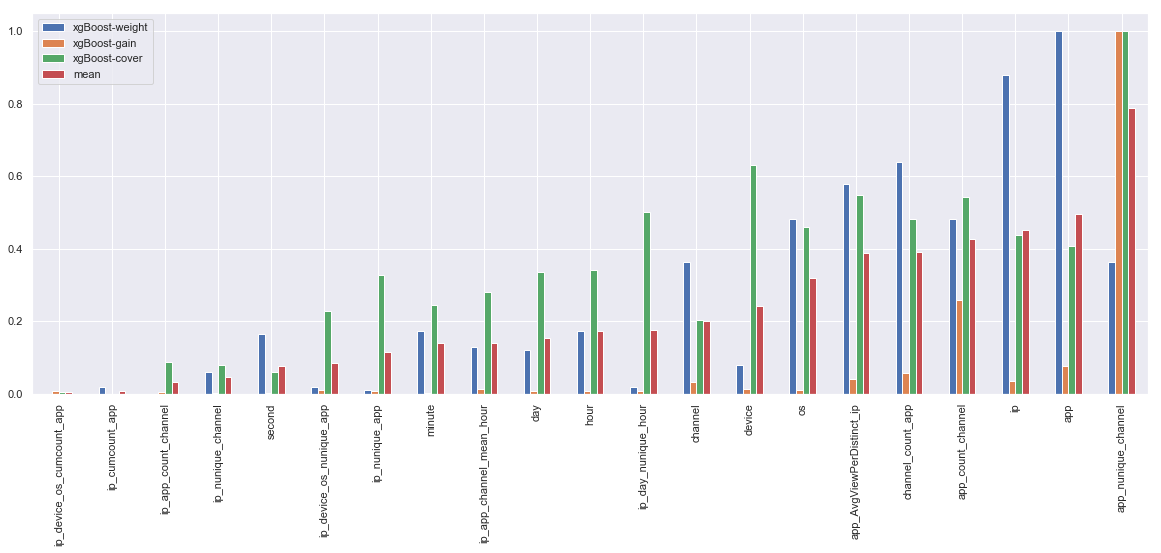

In [282]:
# Get xgBoost importances
importance_dict = {}
for import_type in ['weight', 'gain', 'cover']:
    importance_dict['xgBoost-'+import_type] = clf_xgBoost.get_booster(
    ).get_score(importance_type=import_type)

# MinMax scale all importances
importance_df = pd.DataFrame(importance_dict).fillna(0)
importance_df = pd.DataFrame(
    MinMaxScaler().fit_transform(importance_df),
    columns=importance_df.columns,
    index=importance_df.index
)

# Create mean column
importance_df['mean'] = importance_df.mean(axis=1)
# Rename the index
for i in importance_df.index:
    importance_df = importance_df.rename(index={i: feature_map[i]})

# Plot the feature importances
importance_df.sort_values('mean').plot(kind='bar', figsize=(20, 7))

In [294]:
selected_feat_xgb = importance_df.sort_values('mean', ascending = False).axes[0].tolist()[:10]
selected_feat_xgb

['app_nunique_channel',
 'app',
 'ip',
 'app_count_channel',
 'channel_count_app',
 'app_AvgViewPerDistinct_ip',
 'os',
 'device',
 'channel',
 'ip_day_nunique_hour']

### Feature Importance -- LightGBM

In [116]:
clf_lgb = LGBMClassifier()
clf_lgb.fit(np.array(X), np.array(y))

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [183]:
feature_map = {}
for i,feature in enumerate(X.columns):
    feature_map['Column_'+str(i)] = feature

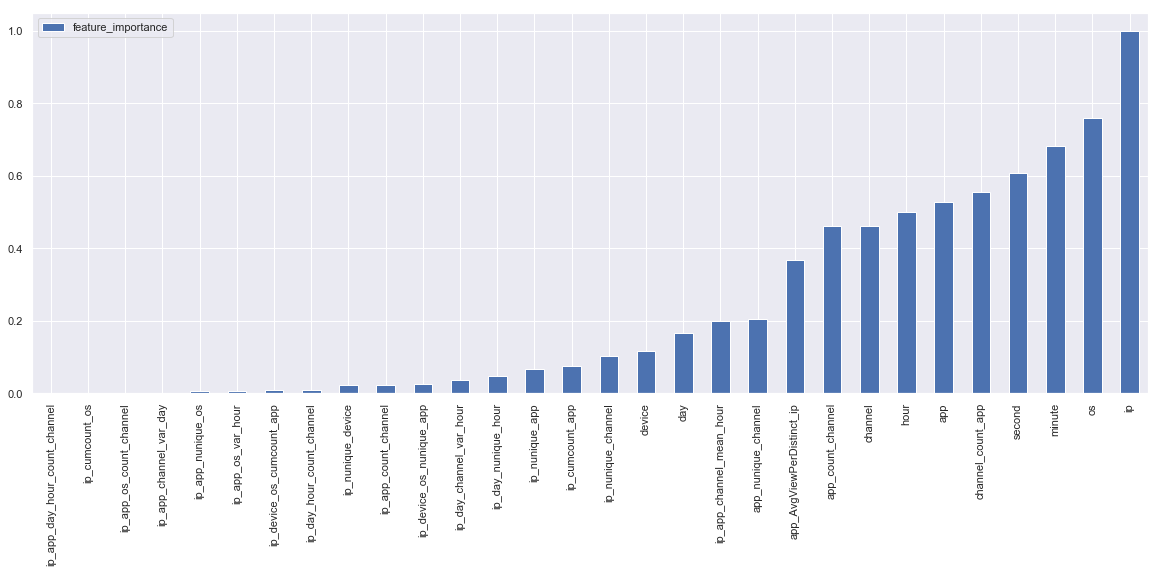

In [192]:
importance_dict = {}
importance_dict = clf_lgb.feature_importances_

# MinMax scale all importances
importance_df2 = pd.DataFrame(importance_dict)
importance_df2 = pd.DataFrame(
    MinMaxScaler().fit_transform(importance_df2),
    columns=importance_df2.columns,
    index=importance_df2.index
)

# Rename the index
for i in importance_df2.index:
    importance_df2 = importance_df2.rename(index={i: feature_map['Column_'+str(i)]})
importance_df2 = importance_df2.rename(columns ={0: 'feature_importance'})
    
# Plot the feature importances
importance_df2.sort_values(by='feature_importance').plot(kind='bar', figsize=(20, 7))

In [291]:
selected_feat_lgb =importance_df2.sort_values('feature_importance', ascending = False).axes[0].tolist()[:10]
selected_feat_lgb

['ip',
 'os',
 'minute',
 'second',
 'channel_count_app',
 'app',
 'hour',
 'channel',
 'app_count_channel',
 'app_AvgViewPerDistinct_ip']

### Feature Importance -- Gradient Boosting

In [225]:
clf_gb = GradientBoostingClassifier()
clf_gb.fit(np.array(X), np.array(y))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

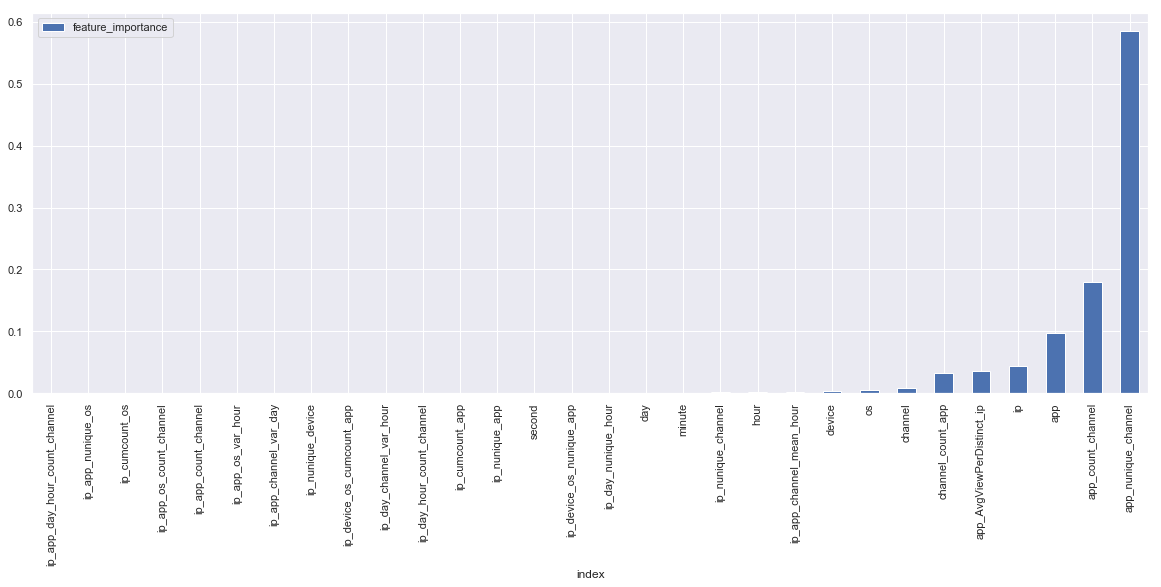

In [262]:
importance_df3 =[]
importance_df3 = pd.concat([pd.DataFrame(X.columns), 
                            pd.DataFrame(clf_gb.feature_importances_)], axis = 1)
importance_df3.columns=['index', 'feature_importance']
importance_df3 = importance_df3.set_index('index')
importance_df3.sort_values('feature_importance').plot(kind='bar', figsize=(20, 7))

In [292]:
selected_feat_gb =importance_df3.sort_values('feature_importance', ascending = False).axes[0].tolist()[:10]
selected_feat_gb

['app_nunique_channel',
 'app_count_channel',
 'app',
 'ip',
 'app_AvgViewPerDistinct_ip',
 'channel_count_app',
 'channel',
 'os',
 'device',
 'ip_app_channel_mean_hour']

### Feature Importance -- Random Forest

In [263]:
clf_rf = RandomForestClassifier()
clf_rf.fit(np.array(X), np.array(y))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

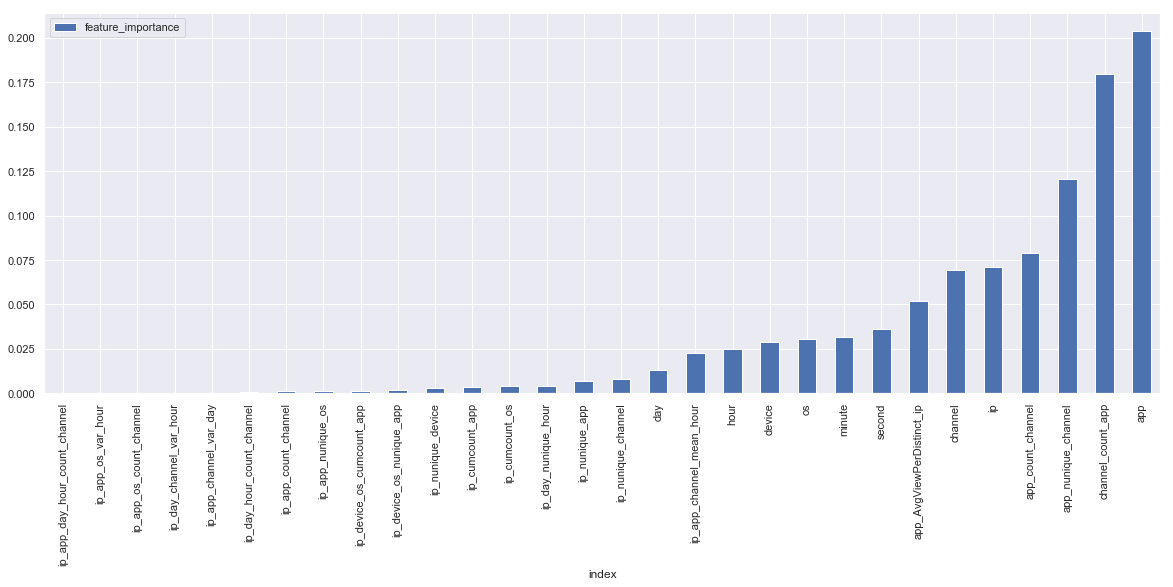

In [273]:
importance_df4 =[]
importance_df4 = pd.concat([pd.DataFrame(X.columns), 
                            pd.DataFrame(clf_rf.feature_importances_)], axis = 1)
importance_df4.columns=['index', 'feature_importance']
importance_df4 = importance_df4.set_index('index')
importance_df4.sort_values('feature_importance').plot(kind='bar', figsize=(20, 7))

In [293]:
selected_feat_rf =importance_df4.sort_values('feature_importance', ascending = False).axes[0].tolist()[:10]
selected_feat_rf

['app',
 'channel_count_app',
 'app_nunique_channel',
 'app_count_channel',
 'ip',
 'channel',
 'app_AvgViewPerDistinct_ip',
 'second',
 'minute',
 'os']

#### Merge Features

In [304]:
score = pd.Series(np.arange(10, 0, -1))
selected_feat_rf_score = pd.concat([pd.DataFrame(selected_feat_rf),score], axis = 1)
selected_feat_rf_score.columns=['feature', 'score']

selected_feat_gb_score = pd.concat([pd.DataFrame(selected_feat_gb),score], axis = 1)
selected_feat_gb_score.columns=['feature', 'score']

selected_feat_lgb_score = pd.concat([pd.DataFrame(selected_feat_lgb),score], axis = 1)
selected_feat_lgb_score.columns=['feature', 'score']

selected_feat_xgb_score = pd.concat([pd.DataFrame(selected_feat_xgb),score], axis = 1)
selected_feat_xgb_score.columns=['feature', 'score']

In [314]:
merge_score = selected_feat_rf_score.merge(right = selected_feat_gb_score, how = 'outer', on = 'feature').\
                                     merge(right = selected_feat_lgb_score, how = 'outer', on = 'feature').\
                                     merge(right = selected_feat_xgb_score, how = 'outer', on = 'feature')

In [325]:
features = list(merge_score['feature'])

In [326]:
features

['app',
 'channel_count_app',
 'app_nunique_channel',
 'app_count_channel',
 'ip',
 'channel',
 'app_AvgViewPerDistinct_ip',
 'second',
 'minute',
 'os',
 'device',
 'ip_app_channel_mean_hour',
 'hour',
 'ip_day_nunique_hour']

#### Select model with the features selected

In [352]:
# Fit xgBoost models
X = np.array(train_fe.drop(['is_attributed'], axis=1))
y = np.array(train_fe['is_attributed'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf_xgBoost = XGBClassifier() 
clf_xgBoost.fit(X_train, y_train)
pred = clf_xgBoost.predict(X_test)
score_xbg = roc_auc_score(y_test, pred)

In [353]:
score_xbg

0.9100101557490071

In [354]:
# Fit lgb models
clf_lgb = LGBMClassifier()
clf_lgb.fit(X_train, y_train)
pred = clf_lgb.predict(X_test)
score_lgb = roc_auc_score(y_test, pred)

In [355]:
score_lgb

0.9106622062103277

In [356]:
# Fit gb models
clf_gb = GradientBoostingClassifier()
clf_gb.fit(X_train, y_train)
pred = clf_gb.predict(X_test)
score_gb = roc_auc_score(y_test, pred)

In [357]:
score_gb

0.9160999355059481

In [358]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
pred = rfc.predict(X_test)
score_rf = roc_auc_score(y_test, pred)

In [359]:
score_rf 

0.9130389909203751